In [48]:
"""IMPORT BIBLIOTEK"""
import mne 
import matplotlib.pyplot as plt
import numpy as np 
from mne.preprocessing import ICA, create_eog_epochs, create_ecg_epochs #funkcje ica
from mne_icalabel import label_components #ica-label algorytm
import onnxruntime #biblioteka do obsługi ica-label
#backend matplotliba 
%matplotlib qt 

In [49]:
"""WSTĘPNE USTAWIENIA PRZED WCZYTANIEM SYGNAŁU"""
d_path = "eeg_files/20241017_kp.bdf" #ścieżka do pliku
ch_eog = ["EXG1","EXG2"] #zdefiniowanie dedykowanych kanałów EOG
ch_ecg = ["EXG3","EXG4"] #zdefiniowanie dedykowanych kanałów ECG
ch_exclude = [f"EXG{i}" for i in range(5,9)] #wykluczenie kanałów niewykorzystanych w badaniu

In [50]:
"""ZAŁADOWANIE SYGNAŁU I USTAWIENIE UKŁADU ELEKTROD"""
raw_original = mne.io.read_raw_bdf(
    d_path, preload = True, eog = ch_eog, misc = ch_ecg, exclude = ch_exclude 
)
raw_original.set_montage("biosemi64") #ustawienie montazu biosemi


Extracting EDF parameters from /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/eeg_files/20241017_kp.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 2928639  =      0.000 ...  1430.000 secs...


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [51]:
"""STWORZENIE KOPI BAZOWEGO SYGNAŁU
    FILTR NOTCH
    OZNACZENIE BAD_CHANNELS
    INTERPOLACJA BAD_CHANNELS
    USTAWIENIE ŚREDNIEJ REFERENCJI
"""
notch_freq = 50
raw = raw_original.copy()
raw.notch_filter(notch_freq)
raw.info["bads"] = ["T7","TP7","POz","CP1","AFz","C3"]
raw.interpolate_bads(reset_bads=True)
raw.set_eeg_reference('average')

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 13517 samples (6.600 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 95.0 mm
Computing interpolation matrix from 58 sensor positions
Interpolating 6 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [54]:
"""STWORZENIE KOPI DO ADNOTACJI"""
raw_for_annotation = raw.copy()


In [55]:
"""FILTRACJA""" 
raw_for_annotation.filter(l_freq=1.0,h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.9s


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

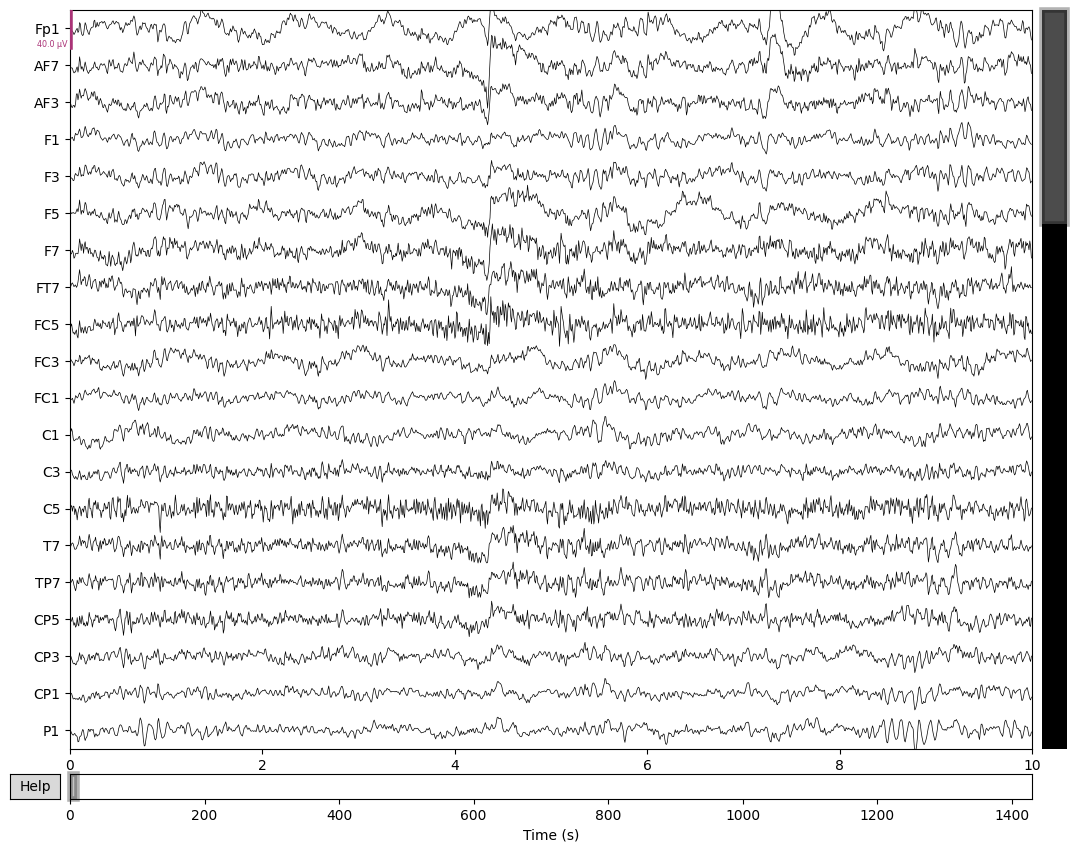

Channels marked as bad:
none


In [56]:
raw_for_annotation.plot()

In [57]:
"""USTAWIENIE ADNOTACJI DLA SEGMENTÓW Z ARTEFAKTEM RUCHOWYM"""
onset_bad_segments = [492.0,1346.0,965.0]
duration_bad_segments = [14.0,22.0,20.0]
description_bad_segments = ["BAD_Oz_movement_artifact","BAD_movement_POz_artifact","BAD_movement_artifact"]
my_annotations = mne.Annotations(onset=onset_bad_segments,duration=duration_bad_segments,description=description_bad_segments)
raw_for_annotation.set_annotations(my_annotations)

<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

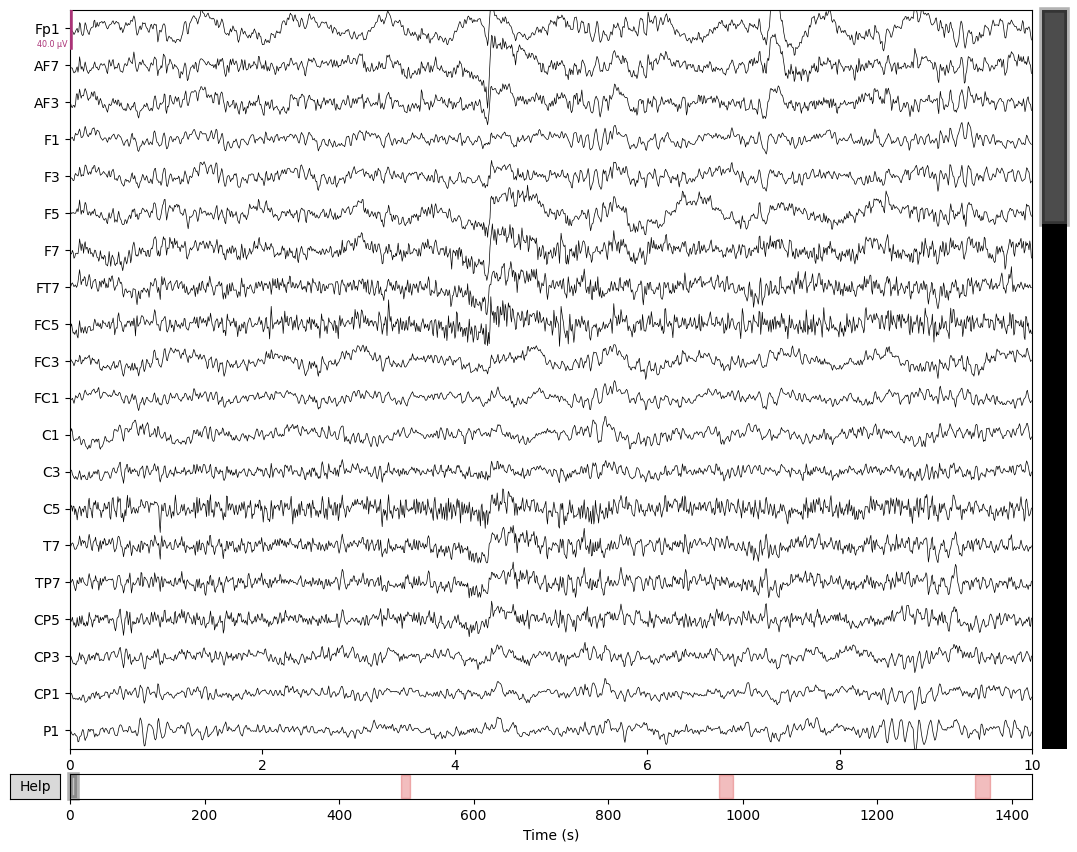

Channels marked as bad:
none


In [58]:
raw_for_annotation.plot()

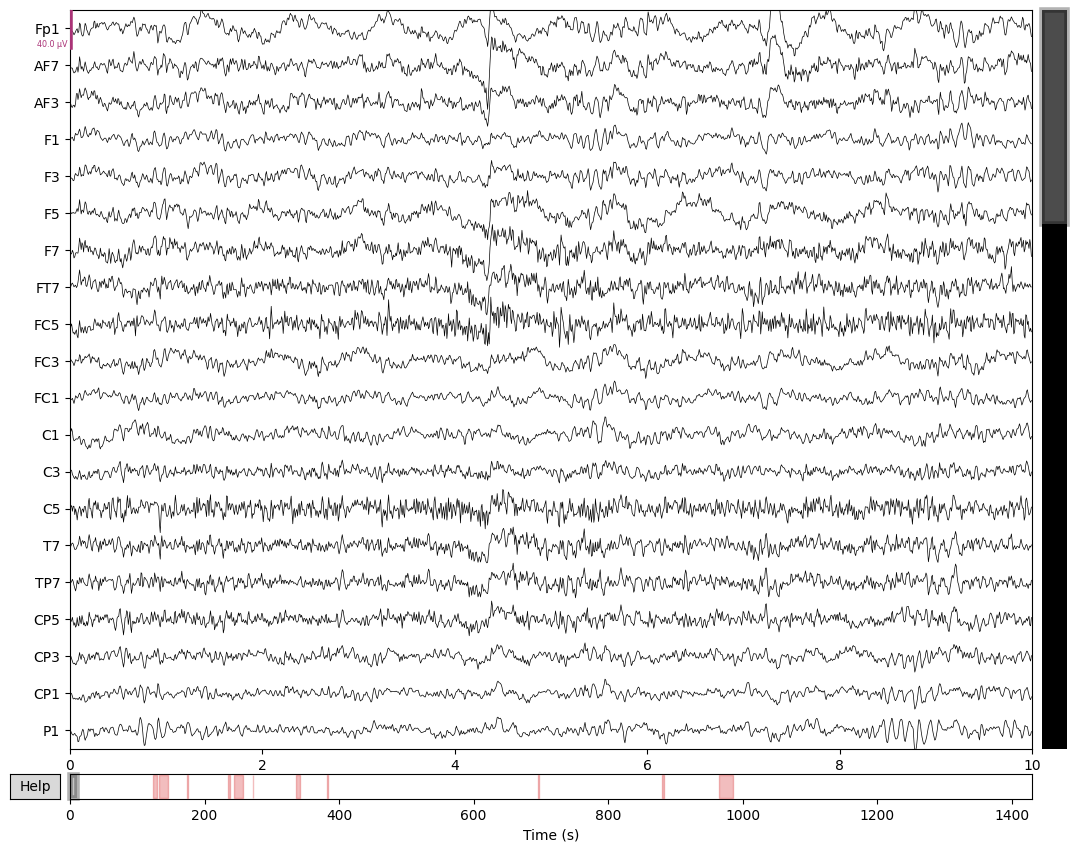

Channels marked as bad:
none


In [17]:
raw_for_annotation.plot()

In [21]:
raw_for_annotation

<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [26]:
print(raw_for_annotation.annotations)

<Annotations | 27 segments: BAD_ (26), BAD_movement_artifact (1)>


In [27]:
eog_events = mne.preprocessing.find_eog_events(raw,ch_name=ch_eog)

Using EOG channels: EXG1, EXG2
EOG channel index for this subject is: [64 65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 421 significant peaks
Number of EOG events detected: 421


In [29]:
ecg_events = mne.preprocessing.find_ecg_events(raw,ch_name="EXG3")

Using channel EXG3 to identify heart beats.
Setting up band-pass filter from 5 - 35 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 5.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 4.75 Hz)
- Upper passband edge: 35.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 35.25 Hz)
- Filter length: 20480 samples (10.000 s)

Number of ECG events detected : 1382 (average pulse 57.98601398601399 / min.)


In [59]:
"""TWORZENIE EPOK"""
eog_epochs = mne.preprocessing.create_eog_epochs(raw,ch_name=ch_eog,preload=True)
ecg_epochs = mne.preprocessing.create_ecg_epochs(raw,ch_name="EXG3",preload=True)

Using EOG channels: EXG1, EXG2
EOG channel index for this subject is: [64 65]
Filtering the data to remove DC offset to help distinguish blinks from saccades
Selecting channel EXG2 for blink detection
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 20480 samples (10.000 s)

Now detecting blinks and generating corresponding events
Found 421 significant peaks
Number of EOG events detected: 421
Not setting metadata
421 matching events found
No baseline correction applied
Using data from preloaded Raw for 421 events and 2049 original time points ...
0 bad epochs dropped
Using channel E

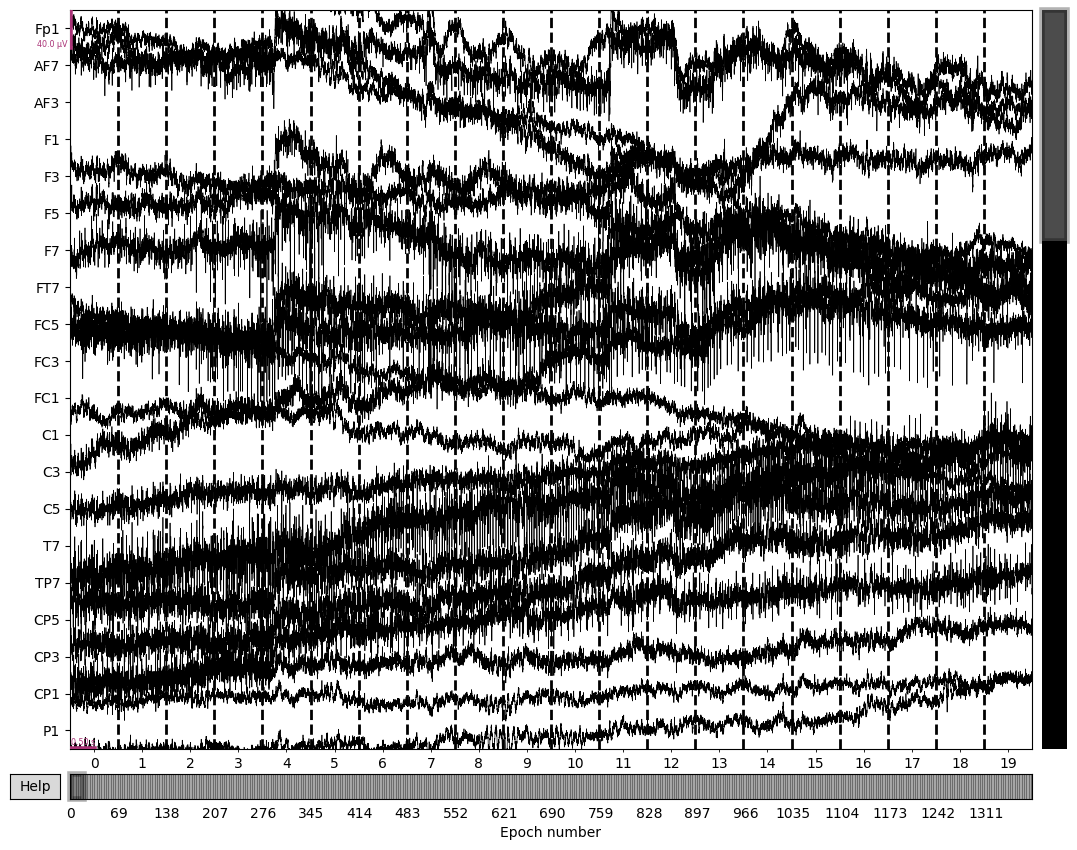

In [60]:
ecg_epochs.plot()

In [61]:
"""UTWORZENIE KOPI DO ICA"""
raw_for_ica_fitting = raw.copy() 

In [62]:
"""USTAWIENIE ADNOTACJI DLA RAW DO ICA"""
raw_for_ica_fitting.set_annotations(raw_for_annotation.annotations) 

<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [63]:
"""USTAWIENIE FILTRACJI DLA ZGODNEJ Z ICA-Label"""
raw_for_ica_fitting.filter(l_freq=1.0,h_freq=100) 

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 1e+02 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 100.00 Hz
- Upper transition bandwidth: 25.00 Hz (-6 dB cutoff frequency: 112.50 Hz)
- Filter length: 6759 samples (3.300 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.7s


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

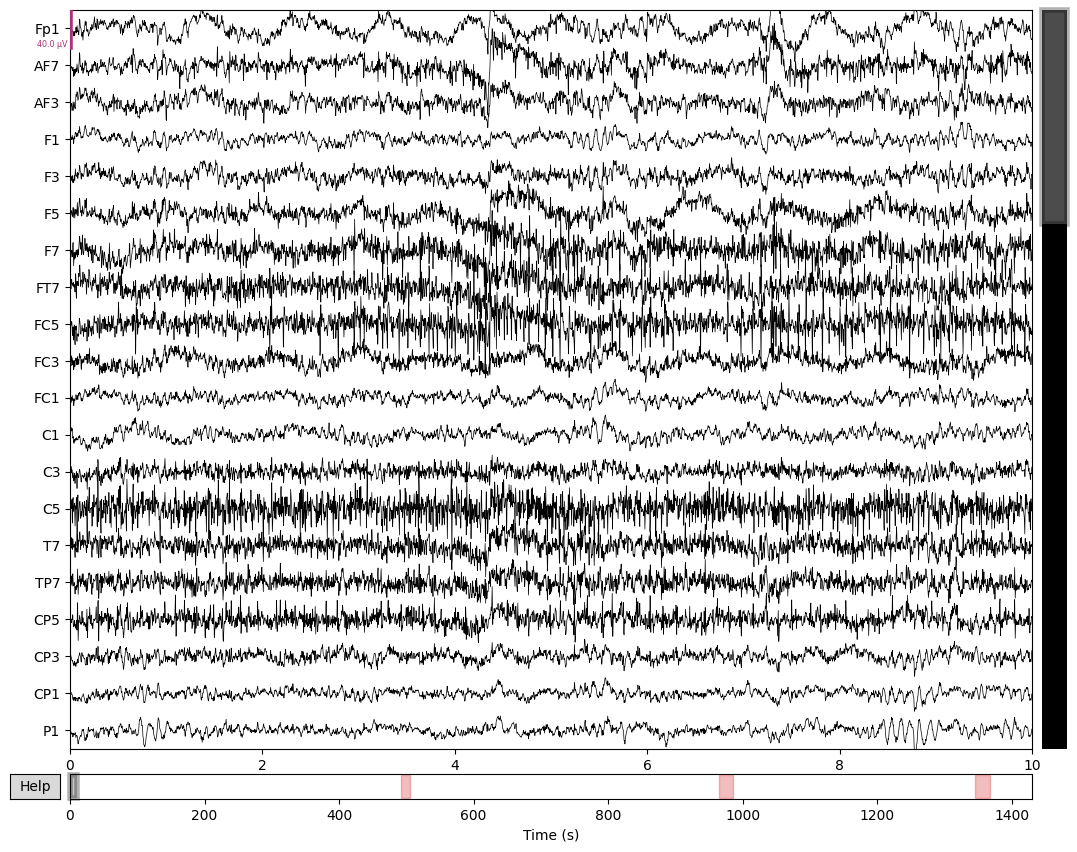

Channels marked as bad:
none
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[]
Channels marked as bad:
none


In [64]:
raw_for_ica_fitting.plot()

In [40]:
#"""ZAINICJOWANIE ALGORYTMU ICA"""
#ica = ICA(
#    max_iter="auto",  #automatyczna liczba iteracji
#    method="infomax",  #wymog ica-label
#    random_state=97, #ziarno
#    fit_params=dict(extended=True), #wymog ica-label
#)
#ica.fit(raw_for_ica_fitting,reject_by_annotation=True)  
#ica.save("hope_its_last-ica.fif",overwrite=True,verbose=None)

Fitting ICA to data using 64 channels (please be patient, this may take a while)
Omitting 104745 of 2928640 (3.58%) samples, retaining 2823895 (96.42%) samples.
Selecting by non-zero PCA components: 57 components
Computing Extended Infomax ICA
Fitting ICA took 433.8s.
Writing ICA solution to /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/hope_its_last-ica.fif...


Method,infomax
Fit parameters,extended=Truemax_iter=500
Fit,500 iterations on raw data (2823895 samples)
ICA components,57
Available PCA components,64
Channel types,eeg
ICA components marked for exclusion,—


Reading /Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/hope_its_last-ica.fif ...
Now restoring ICA solution ...
Ready.
Creating RawArray with float64 data, n_channels=59, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


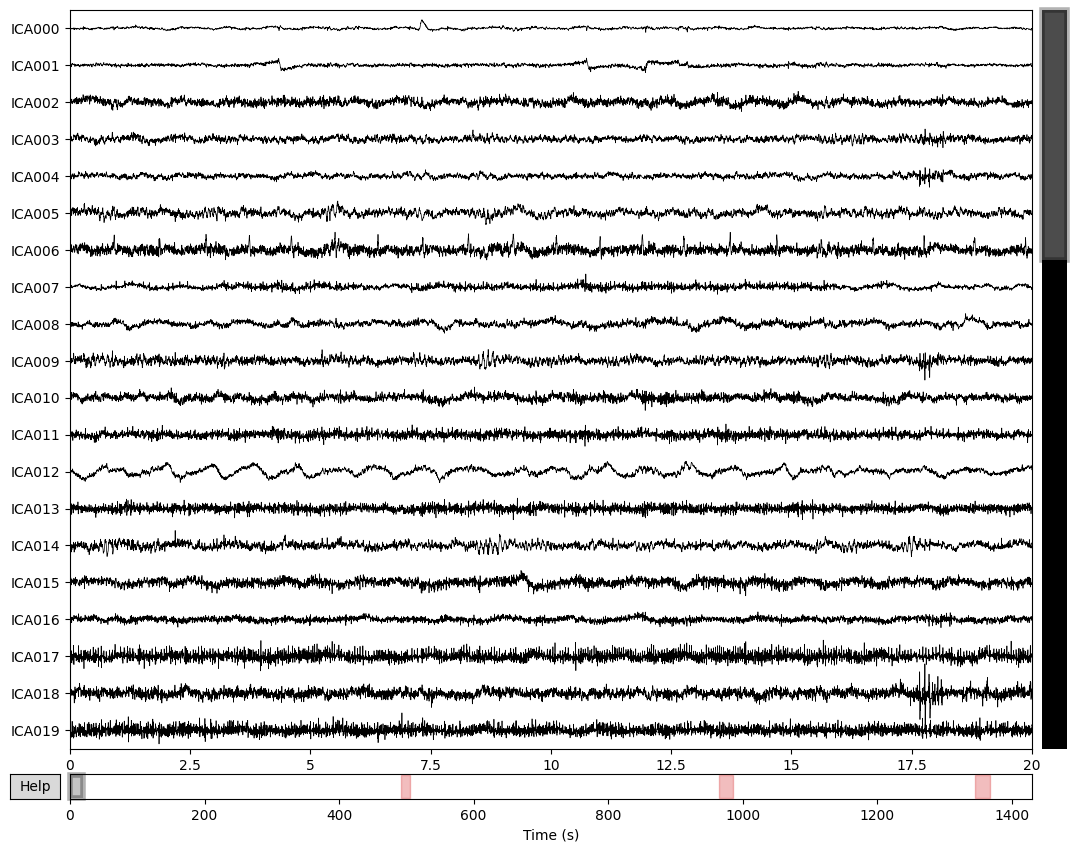

In [65]:
ica=mne.preprocessing.read_ica("/Users/szymbierz/Desktop/wszystko/notebooks/statystyka/inne/eeg/hope_its_last-ica.fif")
ica.plot_sources(raw)

Creating RawArray with float64 data, n_channels=59, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


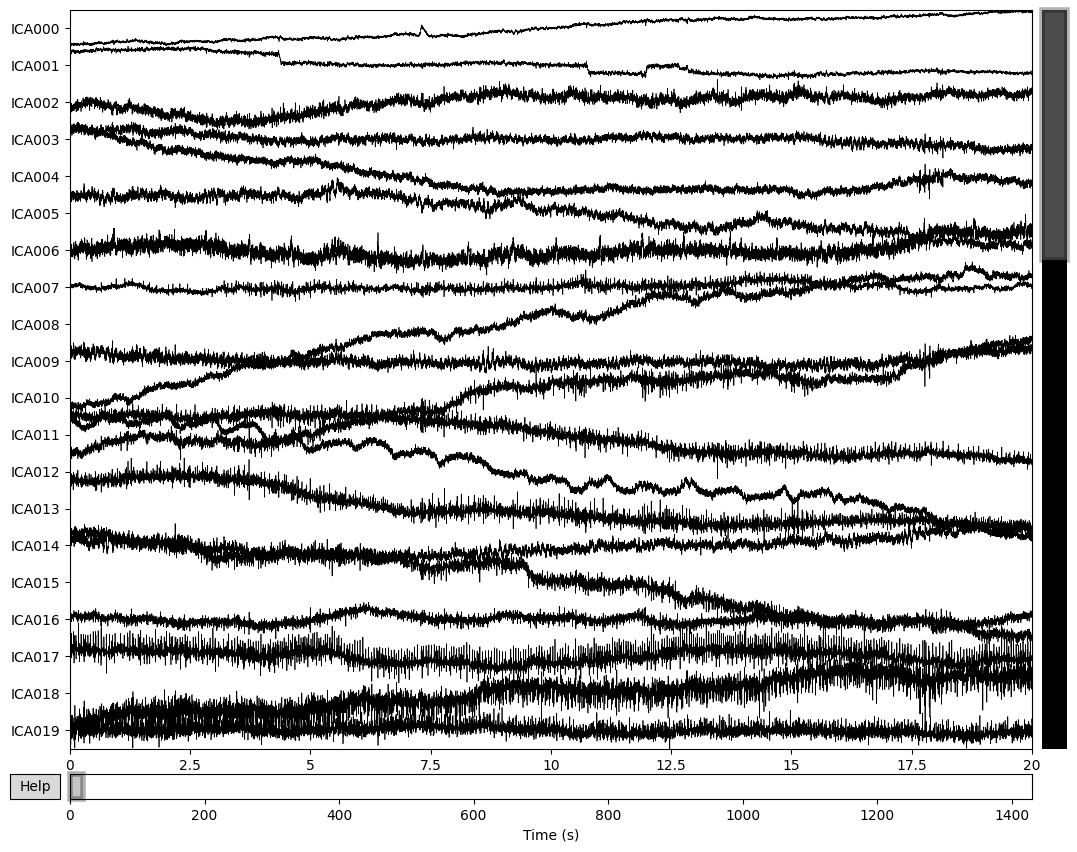

In [66]:
ica.plot_sources(raw)

In [68]:
ic_labels_1 = label_components(raw_for_ica_fitting, ica, method='iclabel')
labels_1 = ic_labels_1["labels"]

In [69]:
labels_list = ic_labels_1["labels"]
count_other = labels_list.count("other")

print(f"Liczba komponentów oznaczonych jako 'other': {count_other}")
print(count_other)

Liczba komponentów oznaczonych jako 'other': 11
11


In [77]:
emg_indices,emg_scores = ica.find_bads_muscle(raw_for_ica_fitting)

Setting 114688 of 2928640 (3.92%) samples to NaN, retaining 2813952 (96.08%) samples.
Effective window size : 1.000 (s)


In [78]:
print(emg_indices)

[2, 7, 8, 10, 11, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 32, 33, 34, 35, 44]


In [85]:
for idx,label in enumerate(labels_1):
    if label == "other":
        print(f"{idx} : {label}")

18 : other
31 : other
33 : other
37 : other
39 : other
43 : other
45 : other
47 : other
50 : other
52 : other
56 : other


In [90]:
print(eog_indices)
print(ecg_indices) 

[np.int64(1), np.int64(12)]
[np.int64(6), np.int64(37), np.int64(40)]


In [101]:
print(labels_1[11])

muscle artifact


In [135]:
ica.plot_properties(raw,picks=[2])


    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
715 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>]

# for idx,label in enumerate(labels_1):
    if label == "other":
        print(f"{idx} : {label}")

In [122]:
print(emg_indices)

[2, 7, 8, 10, 11, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 32, 33, 34, 35, 44]


Creating RawArray with float64 data, n_channels=59, n_times=2928640
    Range : 0 ... 2928639 =      0.000 ...  1430.000 secs
Ready.


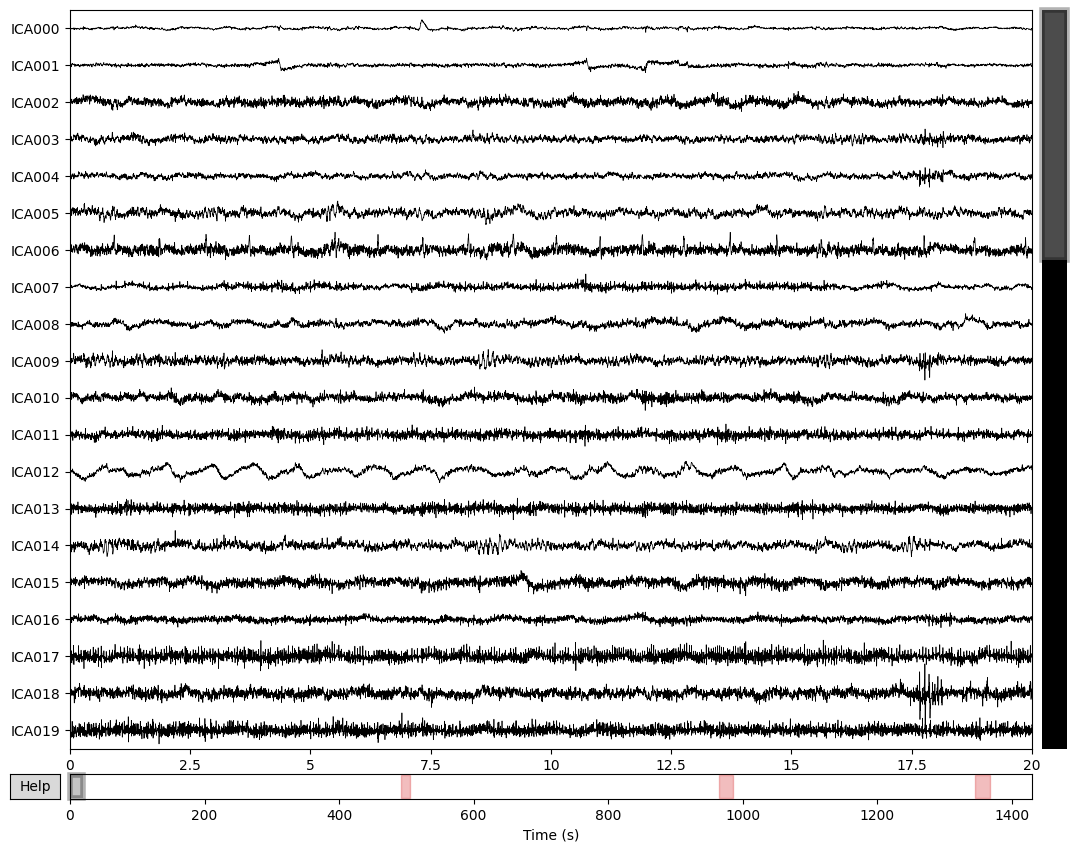

In [175]:
ica.plot_sources(raw_for_ica_fitting)

In [186]:
print(labels_1)

['eye blink', 'eye blink', 'brain', 'brain', 'channel noise', 'brain', 'heart beat', 'muscle artifact', 'eye blink', 'brain', 'eye blink', 'muscle artifact', 'channel noise', 'muscle artifact', 'brain', 'brain', 'brain', 'muscle artifact', 'other', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'muscle artifact', 'channel noise', 'muscle artifact', 'muscle artifact', 'brain', 'muscle artifact', 'brain', 'muscle artifact', 'muscle artifact', 'other', 'muscle artifact', 'other', 'brain', 'muscle artifact', 'channel noise', 'other', 'brain', 'other', 'brain', 'channel noise', 'brain', 'other', 'channel noise', 'other', 'channel noise', 'other', 'channel noise', 'channel noise', 'other', 'channel noise', 'other', 'brain', 'brain', 'channel noise', 'other']


In [138]:
plt.close("all")

In [139]:
print(eog_indices)


[np.int64(1), np.int64(12)]


In [140]:
print(ecg_indices)

[np.int64(6), np.int64(37), np.int64(40)]


In [189]:
ica.plot_compone

    Using multitaper spectrum estimation with 7 DPSS windows
Not setting metadata
686 matching events found
No baseline correction applied
0 projection items activated


[<Figure size 700x600 with 6 Axes>]

2025-05-12 18:57:30.336 Python[4793:12138254] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-12 18:57:30.336 Python[4793:12138254] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-12 18:57:30.336 Python[4793:12138254] Text input context does not respond to _valueForTIProperty:
2025-05-12 18:58:15.098 Python[4793:12138254] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-12 18:58:15.098 Python[4793:12138254] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-12 18:58:15.098 Python[4793:12138254] Text input context does not respond to _valueForTIProperty:


In [161]:
print(emg_indices)

[2, 7, 8, 10, 11, 13, 15, 16, 17, 19, 20, 21, 22, 23, 24, 25, 27, 29, 30, 32, 33, 34, 35, 44]


In [169]:
for idx,label in enumerate(labels_1):
    if label == "muscle artifact":
        print(f"{idx} : {label}")

7 : muscle artifact
11 : muscle artifact
13 : muscle artifact
17 : muscle artifact
19 : muscle artifact
20 : muscle artifact
21 : muscle artifact
22 : muscle artifact
24 : muscle artifact
25 : muscle artifact
27 : muscle artifact
29 : muscle artifact
30 : muscle artifact
32 : muscle artifact
35 : muscle artifact


In [208]:
#15 16  18  10 23 33 44
ica_exclude = labels_1
ica.exclude = ica_exclude 

Applying ICA to Raw instance
    Transforming to ICA space (57 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


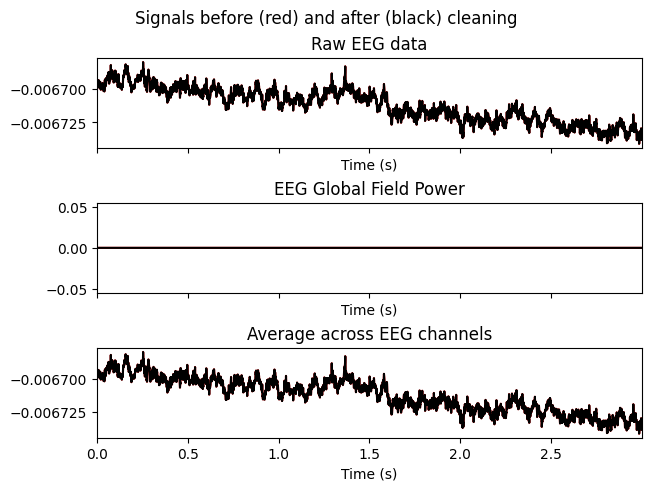

2025-05-12 19:11:22.062 Python[4793:12138254] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-12 19:11:22.062 Python[4793:12138254] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-12 19:11:22.062 Python[4793:12138254] Text input context does not respond to _valueForTIProperty:
2025-05-12 19:11:24.491 Python[4793:12138254] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-12 19:11:24.491 Python[4793:12138254] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-12 19:11:24.491 Python[4793:12138254] Text input context does not respond to _valueForTIProperty:


In [209]:

ica.plot_overlay(raw,exclude=ica_exclude,picks=["AFz"])

In [205]:
raw_cleaned = raw.copy()
ica.apply(raw_cleaned,exclude=ica.exclude)

Applying ICA to Raw instance
    Transforming to ICA space (57 components)
    Zeroing out 0 ICA components
    Projecting back using 64 PCA components


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

In [210]:
raw_main_analysis = raw_cleaned.copy() 
raw_main_analysis.filter(l_freq=0.1,h_freq=40)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 67585 samples (33.000 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.0s


<RawEDF | 20241017_kp.bdf, 69 x 2928640 (1430.0 s), ~1.51 GiB, data loaded>

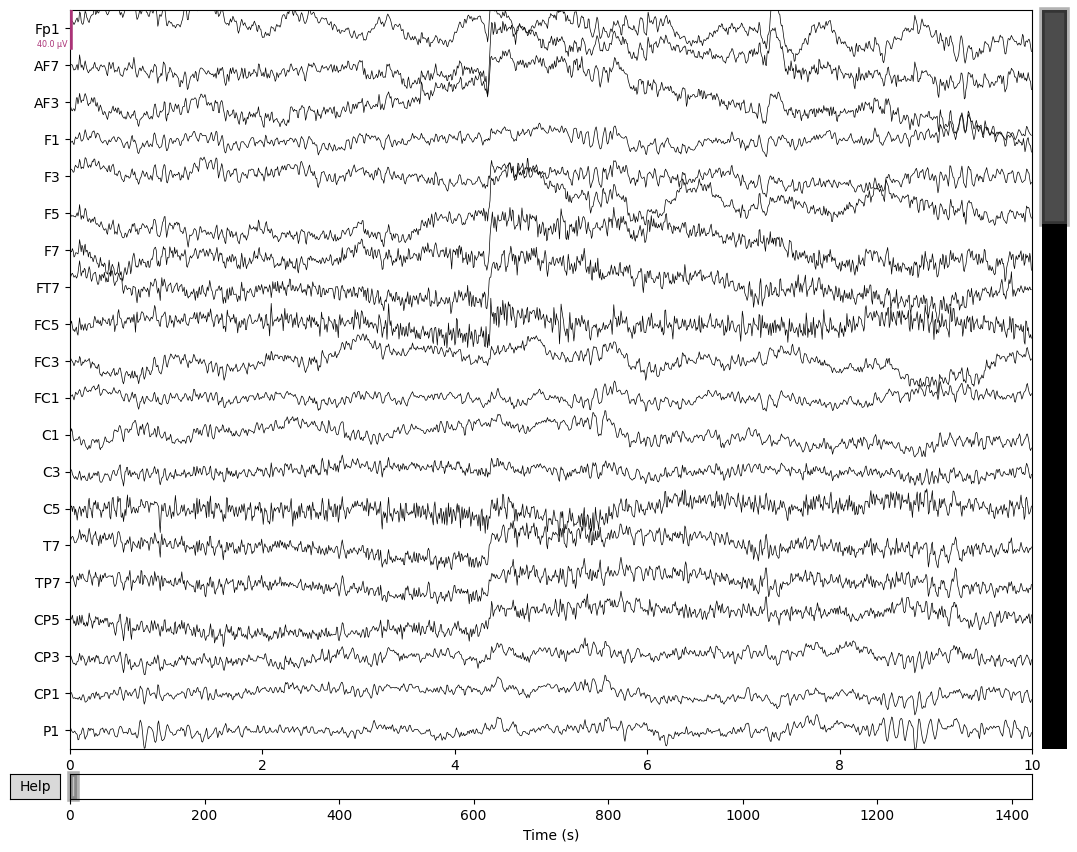

2025-05-12 19:12:29.245 Python[4793:12138254] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-12 19:12:29.245 Python[4793:12138254] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-12 19:12:29.245 Python[4793:12138254] Text input context does not respond to _valueForTIProperty:


Channels marked as bad:
none


2025-05-12 19:12:31.180 Python[4793:12138254] _TIPropertyValueIsValid called with 16 on nil context!
2025-05-12 19:12:31.180 Python[4793:12138254] imkxpc_getApplicationProperty:reply: called with incorrect property value 16, bailing.
2025-05-12 19:12:31.180 Python[4793:12138254] Text input context does not respond to _valueForTIProperty:


In [212]:
raw_main_analysis.plot()